In [1]:
%matplotlib inline

import time
import redis
import matplotlib.pyplot as plt

In [20]:
CFG = {
    "runs": 1000,
    "key": 'benchmark',
    "avg_loops": 1000
}

In [29]:
r = redis.Redis()
r.set("theEnd", "Thank you!")
r.get("theEnd")

b'Thank you!'

In [13]:
def bench_normal(persist=False):
    loop = 1
    data = {}
    
    for avg_loop in range(CFG['avg_loops']):
        while loop <= CFG['runs']:
            start_time = time.time()
            r = redis.Redis()

            if persist:
                r.config_set("appendonly", "yes")
            else:
                r.config_set("appendonly", "no")

            for value in range(loop):
                r.set(CFG['key'], value)
                r.get(CFG['key'])

            end_time = time.time()
            
            if not data.get(loop):
                data[loop] = 0

            data[loop] += (end_time - start_time)/CFG['avg_loops']
            loop += 1
    
    return data

In [15]:
def bench_pipelined(persist=False):
    loop = 1
    data = {}
    
    for avg_loop in range(CFG['avg_loops']):
        while loop <= CFG['runs']:
            start_time = time.time()
            r = redis.Redis()

            if persist:
                r.config_set("appendonly", "yes")
            else:
                r.config_set("appendonly", "no")

            pipeline = r.pipeline()

            for value in range(loop):
                pipeline.set(CFG['key'], value)
                pipeline.get(CFG['key'])

            pipeline.execute()
            end_time = time.time()
            
            if not data.get(loop):
                data[loop] = 0

            data[loop] = (end_time - start_time)/CFG['avg_loops']

            loop += 1
            
    return data

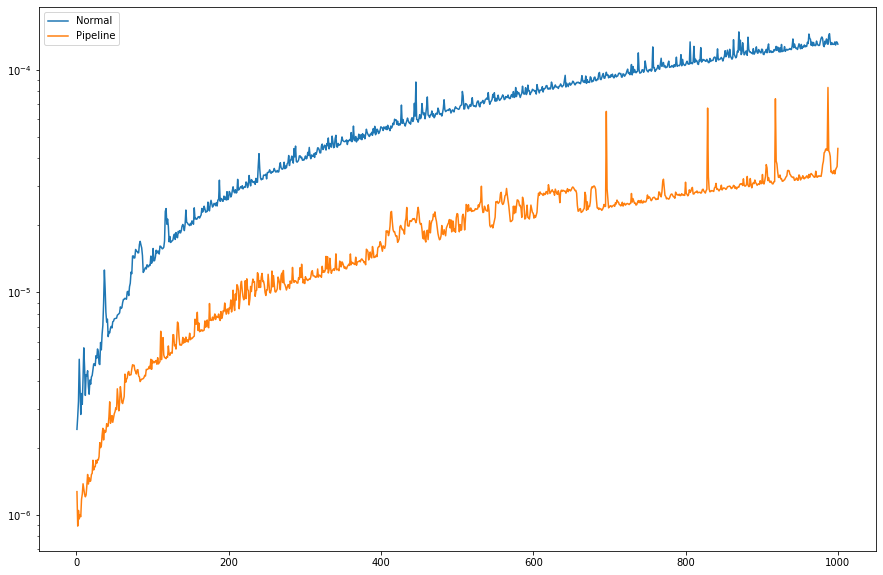

In [21]:
normal = bench_normal()
pipeline = bench_pipelined()

normal_x = list(normal.keys())
normal_y = list(normal.values())

pipeline_x = list(pipeline.keys())
pipeline_y = list(pipeline.values())

plt.figure(figsize=(15, 10))
plt.yscale("log")

plt.plot(normal_x, normal_y, label="Normal")
plt.plot(pipeline_x, pipeline_y, label="Pipeline")

plt.legend(loc='upper left')

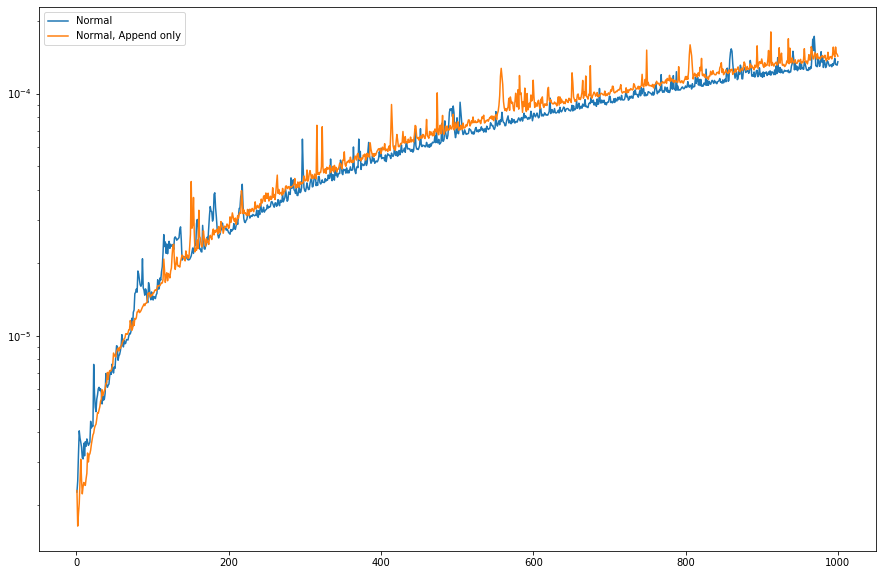

In [22]:
normal = bench_normal()
normal_persist = bench_normal(persist=True)

normal_x = list(normal.keys())
normal_y = list(normal.values())

normal_persist_x = list(normal_persist.keys())
normal_persist_y = list(normal_persist.values())

plt.figure(figsize=(15, 10))
plt.yscale("log")

plt.plot(normal_x, normal_y, label="Normal")
plt.plot(normal_persist_x, normal_persist_y, label="Normal, Append only")

plt.legend(loc='upper left')

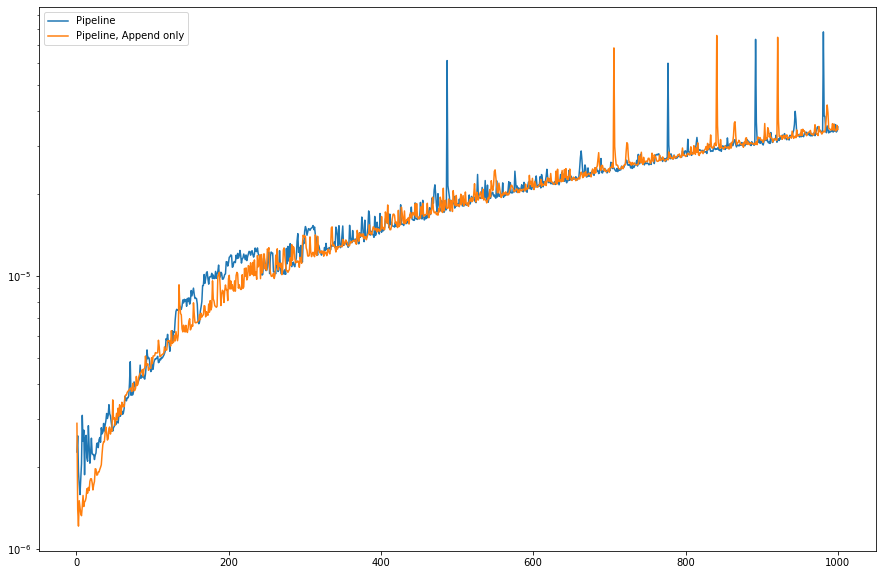

In [23]:
pipeline = bench_pipelined()
pipeline_persist = bench_pipelined(persist=True)

pipeline_x = list(pipeline.keys())
pipeline_y = list(pipeline.values())

pipeline_persist_x = list(pipeline_persist.keys())
pipeline_persist_y = list(pipeline_persist.values())

plt.figure(figsize=(15, 10))
plt.yscale("log")

plt.plot(pipeline_x, pipeline_y, label="Pipeline")
plt.plot(pipeline_persist_x, pipeline_persist_y, label="Pipeline, Append only")

plt.legend(loc='upper left')